 This part is trying to build an A2C model for trading.

In [13]:
import matplotlib.pyplot as plt
import os
import gym
import numpy as np
import tensorflow as tf
import tensorlayer as tl

In [14]:
import gym

import preprocessing_stockenv
import preprocessing_adding_technical_indicator

import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as kl

In [16]:
# actor nn
class Actor(object):

    def __init__(self, state_dim =8, action_dim =3, lr=0.001):
        

        input_layer = tl.layers.Input([None, state_dim])
        layer = tl.layers.Dense(n_units=16, act=tf.nn.relu6)(input_layer)
        layer = tl.layers.Dense(n_units=action_dim)(layer)
#         input_layer =kl.Input(shape=state_dim)
#         layer1 = kl.Dense(12,activation ='elu')(input_layer)
#         layer2 = kl.Dense(3)(layer1)

        self.model = tl.models.Model(inputs=input_layer, outputs=layer)  # define the model in and out
#         self.model = keras.Model(inputs = [input_layer],outputs =[layer2])
        self.model.train()
        self.optimizer = tf.optimizers.Adam(lr)

    def learn(self, state, action, td_error):  # update weights according to cross_entropy
        with tf.GradientTape() as tape:
            _logits = self.model(np.array([state]))
            _exp_v = tl.rein.cross_entropy_reward_loss(
                logits=_logits, actions=[action], rewards=td_error)
        grad = tape.gradient(_exp_v, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_weights))

    def get_action(self, state,epsilon = 0.2):  # option : greedy para to get the max prob
        if np.random.rand() < epsilon:
            return np.random.randint(3)
        else:
            _logits = self.model(np.array([state]))
            _prob = tf.nn.softmax(_logits).numpy()
            return tl.rein.choice_action_by_probs(_prob.ravel())


In [17]:
# critic nn
class Critic(object):

    def __init__(self, state_dim =9, lr=0.01): # 8 or 9 should be more than  actor because need to input action
        input_layer = tl.layers.Input([None, state_dim])
        layer = tl.layers.Dense(n_units=18, act=tf.nn.relu)(input_layer) # 12  is the twice of the input dimension
        layer = tl.layers.Dense(n_units=1, act=None)(layer)  # output one

        self.model = tl.models.Model(inputs=input_layer, outputs=layer)
        self.model.train()
        self.optimizer = tf.optimizers.Adam(lr)

    def learn(self, state, reward, state_, done, action, action_):
        d = 0 if done else 1
        input1 = np.append(state,action).astype(np.float32)
        input2 = np.append(state_,action_).astype(np.float32)

        with tf.GradientTape() as tape:
            v = self.model(np.array([input1]))
            v_ = self.model(np.array([input2])) # new state  value
            td_error = reward + d * gamma * v_ - v
            loss = tf.square(td_error)  # MSE
        grads = tape.gradient(loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return td_error


In [19]:
data = preprocessing_adding_technical_indicator.add_technical_indicator()
env = preprocessing_stockenv.StockEnv(data)
LR_A = 0.001  # learning rate for actor
LR_C = 0.01  # learning rate for critic
decay = 0.005 # learning rate decay
gamma = 0.95 # discount factor

[ 1.00000e+03  0.00000e+00  0.00000e+00  2.62000e+02  0.00000e+00
 -6.66667e+01  4.69697e+01  3.16346e+05]


In [20]:
actor = Actor(8, env.action_space.n, lr=LR_A)
critic = Critic(9, lr=LR_C)

[TL] Input  _inputlayer_3: [None, 8]
[TL] Dense  dense_5: 16 relu6
[TL] Dense  dense_6: 3 No Activation
[TL] Input  _inputlayer_4: [None, 9]
[TL] Dense  dense_7: 18 relu
[TL] Dense  dense_8: 1 No Activation


In [7]:
# def trade_time_unit(env, obs):  #  using greedy policy
#     action = actor.get_action(obs) # get the action
#     print(action)
#     next_state, reward, done, info = env.step(action)
#     return next_state, reward, done, info

In [21]:
def train_one_episode():
    env.reset()
    state = env.reset().astype(np.float32)
    reward_total = 0
    for step in range(2100):
        action = actor.get_action(state)
        next_state, reward, done, info = env.step(action)
        reward_total = reward_total + reward
        next_state = next_state.astype(np.float32)
        action_ = actor.get_action(next_state)
        td_error = critic.learn(state,reward,next_state,done,action, action_)
        actor.learn(state,action,td_error)
        state = next_state
        if done:
            print(state)
            break
    print("For this episode,reward total:{}".format(reward_total))

In [37]:
for i in range(10):
    train_one_episode()

[3.82165e+02 0.00000e+00 0.00000e+00 1.77000e+02 5.20000e-02 8.72270e+00
 5.68858e+01 3.12915e+05]
For this episode,reward total:-617.8350000000003
[9.05382e+02 0.00000e+00 0.00000e+00 1.77000e+02 5.20000e-02 8.72270e+00
 5.68858e+01 3.12915e+05]
For this episode,reward total:-94.61800000000005
[7.71290e+02 0.00000e+00 0.00000e+00 1.77000e+02 5.20000e-02 8.72270e+00
 5.68858e+01 3.12915e+05]
For this episode,reward total:-228.71000000000004
[0.00000e+00 1.79000e+02 6.11700e+00 1.77000e+02 5.20000e-02 8.72270e+00
 5.68858e+01 3.12915e+05]
For this episode,reward total:70.44800000000009
[0.00000e+00 1.78000e+02 8.56000e+00 1.77000e+02 5.20000e-02 8.72270e+00
 5.68858e+01 3.12915e+05]
For this episode,reward total:498.0000000000002
[0.00000e+00 1.84000e+02 2.64900e+00 1.77000e+02 5.20000e-02 8.72270e+00
 5.68858e+01 3.12915e+05]
For this episode,reward total:-536.4250000000004
[0.00000e+00 1.84000e+02 6.76700e+00 1.77000e+02 5.20000e-02 8.72270e+00
 5.68858e+01 3.12915e+05]
For this episo

After running more than 400 episodes, it seems hard to converge.

In [42]:
l =env.money_memory

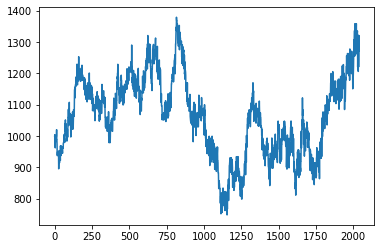

In [46]:
%matplotlib inline
plt.plot(l)
plt.show()